#PROYEK ANALISIS SENTIMEN ( DATA SCRAPING APLIKASI DISCORD)

#Import Library

In [1]:
!pip install sastrawi
!pip install tensorflow
!pip install keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.3 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

from wordcloud import WordCloud  # Membuat visualisasi berbentuk awan kata (word cloud) dari teks

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score
from sklearn.utils.class_weight import compute_class_weight
from transformers import BertTokenizer, BertForSequenceClassification  # BERT
import torch
import csv
import requests
from io import StringIO

#Loading data

In [5]:
df_review_df = pd.read_csv('discord_data.csv')
df_review_df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,dffb5dc1-0e52-48ab-9166-069c0075adcb,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"good job discord, aplikasi yang cukup baik dan...",5,211,273.12 - Stable,2025-04-06 09:02:17,NaN,NaN,273.12 - Stable
1,b0db1c89-e03d-40b3-a905-80bf1856ad86,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Kenapa komunikasi sering terputus, & sekali pu...",1,823,265.15 - Stable,2025-02-10 17:45:30,"Silakan coba restart perangkat Anda, instal ul...",2025-02-10 18:13:34,265.15 - Stable
2,11806425-1efd-4afe-9596-a6f55a8d88fe,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Min ada beberapa bug yaitu ketika mengupload f...,4,38,268.13 - Stable,2025-02-28 00:43:39,NaN,NaN,268.13 - Stable
3,8c580c2a-2a1a-423f-9bdb-9fe5d93ccff5,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Apknya sudah bagus tapi yg harus diperbaiki ad...,2,33,269.11 - Stable,2025-03-06 10:30:04,"Sayangnya, ini bisa terjadi karena masalah mem...",2025-03-06 10:59:26,269.11 - Stable
4,b7a0089c-c6e0-4326-bbe9-ba9176ff0c9c,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Aduh tolong lah discord, saya lagi ikut giveaw...",2,23,266.13 - Stable,2025-02-19 11:19:11,Apakah Anda login di perangkat lain mungkin? C...,2025-02-19 11:49:31,266.13 - Stable


#Cleaning data

In [6]:
df_review_df.isnull().sum() #memeriksa miising value

,0
reviewId,0
userName,0
userImage,0
content,0
score,0
thumbsUpCount,0
reviewCreatedVersion,12913
at,0
replyContent,32025
repliedAt,32025


In [7]:
# mengambil 3 kolom dataset
df_review_df = df_review_df[['content', 'score', 'thumbsUpCount']]
df_review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   content        45000 non-null  object
 1   score          45000 non-null  int64 
 2   thumbsUpCount  45000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.0+ MB


In [8]:
df_review_df.duplicated().sum()


np.int64(6492)

tidak memiliki duplikasi data

#Preprocessing Data

In [9]:
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # menghapus mention
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # menghapus hashtag
    text = re.sub(r'RT[\s]', '', text) # menghapus RT
    text = re.sub(r"http\S+", '', text) # menghapus link
    text = re.sub(r'[0-9]+', '', text) # menghapus angka
    text = re.sub(r'[^\w\s]', '', text) # menghapus karakter selain huruf dan angka

    text = text.replace('\n', ' ') # mengganti baris baru dengan spasi
    text = text.translate(str.maketrans('', '', string.punctuation)) # menghapus semua tanda baca
    text = text.strip(' ') # menghapus karakter spasi dari kiri dan kanan teks
    text = text.lower()
    return text

In [10]:
df_review_df['clean_content'] = df_review_df['content'].apply(cleaningText)
df_review_df[['content', 'clean_content']].head()

,content,clean_content
0,"good job discord, aplikasi yang cukup baik dan...",good job discord aplikasi yang cukup baik dan ...
1,"Kenapa komunikasi sering terputus, & sekali pu...",kenapa komunikasi sering terputus sekali putu...
2,Min ada beberapa bug yaitu ketika mengupload f...,min ada beberapa bug yaitu ketika mengupload f...
3,Apknya sudah bagus tapi yg harus diperbaiki ad...,apknya sudah bagus tapi yg harus diperbaiki ad...
4,"Aduh tolong lah discord, saya lagi ikut giveaw...",aduh tolong lah discord saya lagi ikut giveawa...


In [11]:
def tokenizingText(text):
    text = word_tokenize(text)
    return text

def filteringText(text):
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(['iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy", "polll"])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

def stemmingText(text):

    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    # Memecah teks menjadi daftar kata
    words = text.split()

    # Menerapkan stemming pada setiap kata dalam daftar
    stemmed_words = [stemmer.stem(word) for word in words]

    # Menggabungkan kata-kata yang telah distem
    stemmed_text = ' '.join(stemmed_words)

    return stemmed_text

# To Sentences
def toSentence(list_words): # Mengubah daftar kata menjadi kalimat
    sentence = ' '.join(word for word in list_words)
    return sentence

In [12]:

slang_dict = {
    'gk': 'nggak',
    'ga': 'nggak',
    'ngga': 'nggak',
    'tdk': 'tidak',
    'bgt': 'banget',
    'bgtu': 'begitu',
    'sm': 'sama',
    'sbnrnya': 'sebenarnya',
    'aja': 'saja',
    'jg': 'juga',
    'udh': 'sudah',
    'blm': 'belum',
    'bsk': 'besok',
    'sy': 'saya',
    'dr': 'dari',
    'dgn': 'dengan',
    'tp': 'tapi',
    'krn': 'karena',
    'trs': 'terus',
    'kmrn': 'kemarin',
    'utk': 'untuk',
    'bkn': 'bukan',
    'pls': 'tolong',
    'btw': 'ngomong-ngomong',
    'wkwk': 'haha',
    'lol': 'haha',
    'omg': 'ya ampun',
    'mksh': 'terima kasih',
    'makasih': 'terima kasih',
    'trims': 'terima kasih',
    'thx': 'terima kasih',
    'dpt': 'dapat',
    'lg': 'lagi',
    'ny': 'nya',
    'nya': 'nya',
    'ntr': 'nanti',
    'ajaib': 'ajaib',
    'ngerti': 'mengerti',
    'bingungin': 'membingungkan',
}

# Gabungkan semua slang jadi satu regex
pattern = re.compile(r'\b(' + '|'.join(re.escape(k) for k in slang_dict.keys()) + r')\b', flags=re.IGNORECASE)

def fix_slangwords(text):
    def replace(match):
        word = match.group(0).lower()
        return slang_dict.get(word, word)

    return pattern.sub(replace, text)

# Contoh pemakaian
contoh = "Pls bgt bantuin dgn tugasnya ya. Gk ngerti trs malah pusing wkwk!"
hasil = fix_slangwords(contoh)
print(hasil)


tolong banget bantuin dengan tugasnya ya. nggak mengerti terus malah pusing haha!


In [13]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [14]:
df_review_df['text_casefoldingText'] = df_review_df['clean_content']
# Mengganti kata-kata slang dengan kata-kata standar dan menyimpannya di 'text_slangwords'
df_review_df['text_slangwords'] = df_review_df['text_casefoldingText'].apply(fix_slangwords)

# Memecah teks menjadi token (kata-kata) dan menyimpannya di 'text_tokenizingText'
df_review_df['text_tokenizingText'] = df_review_df['text_slangwords'].apply(tokenizingText)

# Menghapus kata-kata stop (kata-kata umum) dan menyimpannya di 'text_stopword'
df_review_df['text_stopword'] = df_review_df['text_tokenizingText'].apply(filteringText)

# Menggabungkan token-token menjadi kalimat dan menyimpannya di 'text_akhir'
df_review_df['text_akhir'] = df_review_df['text_stopword'].apply(toSentence)

In [15]:
df_review_df

,content,score,thumbsUpCount,clean_content,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir
0,"good job discord, aplikasi yang cukup baik dan...",5,211,good job discord aplikasi yang cukup baik dan ...,good job discord aplikasi yang cukup baik dan ...,good job discord aplikasi yang cukup baik dan ...,"[good, job, discord, aplikasi, yang, cukup, ba...","[good, job, discord, aplikasi, membantu, keseh...",good job discord aplikasi membantu kesehari ha...
1,"Kenapa komunikasi sering terputus, & sekali pu...",1,823,kenapa komunikasi sering terputus sekali putu...,kenapa komunikasi sering terputus sekali putu...,kenapa komunikasi sering terputus sekali putu...,"[kenapa, komunikasi, sering, terputus, sekali,...","[komunikasi, terputus, putus, apk, diulang, bu...",komunikasi terputus putus apk diulang buruk di...
2,Min ada beberapa bug yaitu ketika mengupload f...,4,38,min ada beberapa bug yaitu ketika mengupload f...,min ada beberapa bug yaitu ketika mengupload f...,min ada beberapa bug yaitu ketika mengupload f...,"[min, ada, beberapa, bug, yaitu, ketika, mengu...","[min, bug, mengupload, file, teman, suka, stuc...",min bug mengupload file teman suka stuck akhir...
3,Apknya sudah bagus tapi yg harus diperbaiki ad...,2,33,apknya sudah bagus tapi yg harus diperbaiki ad...,apknya sudah bagus tapi yg harus diperbaiki ad...,apknya sudah bagus tapi yg harus diperbaiki ad...,"[apknya, sudah, bagus, tapi, yg, harus, diperb...","[apknya, bagus, yg, diperbaiki, pengen, voice,...",apknya bagus yg diperbaiki pengen voice chat m...
4,"Aduh tolong lah discord, saya lagi ikut giveaw...",2,23,aduh tolong lah discord saya lagi ikut giveawa...,aduh tolong lah discord saya lagi ikut giveawa...,aduh tolong lah discord saya lagi ikut giveawa...,"[aduh, tolong, lah, discord, saya, lagi, ikut,...","[aduh, tolong, discord, giveaway, last, leave,...",aduh tolong discord giveaway last leave win eh...
...,...,...,...,...,...,...,...,...,...
44995,Good,5,0,good,good,good,[good],[good],good
44996,wah,5,0,wah,wah,wah,[wah],[],
44997,Top,5,0,top,top,top,[top],[top],top
44998,ok,5,0,ok,ok,ok,[ok],[ok],ok


#PELABELAN

In [16]:
from collections import Counter

all_words = [word for tokens in df_review_df['text_stopword'] for word in tokens]
word_freq = Counter(all_words)

for word, freq in word_freq.most_common(150):
    print(f"{word}: {freq}")

bagus: 6499
discord: 6263
nggak: 5174
aplikasi: 4884
login: 4870
tolong: 4154
apk: 2904
bug: 2469
banget: 2469
udah: 2447
masuk: 2415
akun: 2399
good: 2367
update: 2229
kasih: 1957
email: 1847
pas: 1763
perbaiki: 1746
yg: 1665
gw: 1633
game: 1623
suara: 1548
bintang: 1424
suka: 1373
app: 1364
bahasa: 1358
teman: 1342
download: 1322
susah: 1316
nice: 1246
kalo: 1229
mantap: 1225
pake: 1221
indonesia: 1214
bener: 1198
voice: 1186
password: 1162
verifikasi: 1154
hp: 1132
keren: 1034
main: 1025
mohon: 993
dah: 933
jelek: 920
server: 907
gua: 903
chat: 902
orang: 870
salah: 854
bikin: 832
coba: 822
please: 814
gabisa: 801
fix: 793
diperbaiki: 789
kali: 778
temen: 775
aplikasinya: 750
gimana: 736
fitur: 716
ok: 699
kode: 695
membantu: 690
nomor: 682
cant: 679
tau: 676
mulu: 671
verify: 646
kadang: 636
terima: 633
dc: 600
log: 596
register: 595
developer: 555
mabar: 555
ribet: 536
ngobrol: 532
suaranya: 524
masukin: 521
sandi: 505
nih: 489
error: 484
join: 484
invalid: 481
aneh: 463
ni: 460
p

In [17]:
lexicon_positive = dict()
response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')
if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')
    for row in reader:
        lexicon_positive[row[0]] = int(row[1])
else:
    print("Failed to fetch positive lexicon data")

In [18]:
lexicon_negative = dict()
response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')

if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')
    for row in reader:
        lexicon_negative[row[0]] = int(row[1])
else:
    print("Failed to fetch negative lexicon data")


In [19]:
known_words = set(lexicon_positive.keys()).union(set(lexicon_negative.keys()))
unknown_words = [word for word in all_words if word not in known_words]
print(f"Jumlah kata tidak dikenal: {len(set(unknown_words))}")

Jumlah kata tidak dikenal: 22241


In [20]:
all_words = [word for tokens in df_review_df['text_stopword'] for word in tokens]
known_words = set(lexicon_positive.keys()).union(set(lexicon_negative.keys()))
unknown_words = [word for word in all_words if word not in known_words]

from collections import Counter
unknown_freq = Counter(unknown_words)

for word, freq in unknown_freq.most_common(100):
    print(f"{word}: {freq}")

discord: 6263
login: 4870
apk: 2904
bug: 2469
udah: 2447
akun: 2399
update: 2229
email: 1847
perbaiki: 1746
yg: 1665
gw: 1633
bintang: 1424
app: 1364
teman: 1342
download: 1322
kalo: 1229
pake: 1221
indonesia: 1214
voice: 1186
password: 1162
verifikasi: 1154
hp: 1132
keren: 1034
server: 907
orang: 870
bikin: 832
gabisa: 801
fix: 793
diperbaiki: 789
kali: 778
temen: 775
aplikasinya: 750
gimana: 736
fitur: 716
nomor: 682
cant: 679
verify: 646
dc: 600
log: 596
register: 595
developer: 555
mabar: 555
suaranya: 524
masukin: 521
sandi: 505
nih: 489
ni: 460
pakai: 455
knp: 454
karna: 451
lag: 445
tetep: 432
code: 417
account: 412
bermain: 409
g: 405
gitu: 404
video: 403
versi: 398
ulang: 395
like: 395
make: 386
best: 379
mic: 357
semoga: 354
nitro: 353
channel: 351
add: 334
new: 333
ngebug: 325
tambahkan: 324
phone: 323
application: 322
connecting: 309
berkomunikasi: 306
trus: 301
sinyal: 301
cuman: 299
pasword: 297
screen: 297
tulisan: 295
ama: 292
lu: 292
gmail: 291
kek: 291
si: 290
ui: 289

In [21]:
def analysis_lexicon(text):
    score = 0
    for word in text:
        if (word in lexicon_positive):
            score += lexicon_positive[word]
    for word in text:
        if (word in lexicon_negative):
            score += lexicon_negative[word]

        polarity = ''
    if score > 2:
        polarity = 'positif'
    elif score  < -3:
        polarity = 'negatif'
    else:
        polarity = 'netral'

    return score, polarity

In [22]:
results = df_review_df['text_stopword'].apply(analysis_lexicon)
results = list(zip(*results))
df_review_df['polarity_score'] = results[0]
df_review_df['polarity'] = results[1]
print(df_review_df['polarity'].value_counts())

polarity
netral     24222
negatif    11799
positif     8979
Name: count, dtype: int64


In [23]:
df_review_df.sample(20)

,content,score,thumbsUpCount,clean_content,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir,polarity_score,polarity
13668,Discord GK bisa daftar pake nomor sering invalid,5,0,discord gk bisa daftar pake nomor sering invalid,discord gk bisa daftar pake nomor sering invalid,discord nggak bisa daftar pake nomor sering in...,"[discord, nggak, bisa, daftar, pake, nomor, se...","[discord, nggak, daftar, pake, nomor, invalid]",discord nggak daftar pake nomor invalid,-9,negatif
14926,Cocok buat gamer yang ingin voice chat dengan ...,5,0,cocok buat gamer yang ingin voice chat dengan ...,cocok buat gamer yang ingin voice chat dengan ...,cocok buat gamer yang ingin voice chat dengan ...,"[cocok, buat, gamer, yang, ingin, voice, chat,...","[cocok, gamer, voice, chat, suara, jernih]",cocok gamer voice chat suara jernih,9,positif
7552,"Keren ,langsung di perbaiki masalah volume nya...",5,7,keren langsung di perbaiki masalah volume nya ...,keren langsung di perbaiki masalah volume nya ...,keren langsung di perbaiki masalah volume nya ...,"[keren, langsung, di, perbaiki, masalah, volum...","[keren, langsung, perbaiki, volume, mantap]",keren langsung perbaiki volume mantap,8,positif
16994,"Ga bisa login, kode verifikasi tidak valid "" g...",1,0,ga bisa login kode verifikasi tidak valid gimana,ga bisa login kode verifikasi tidak valid gimana,nggak bisa login kode verifikasi tidak valid ...,"[nggak, bisa, login, kode, verifikasi, tidak, ...","[nggak, login, kode, verifikasi, valid, gimana]",nggak login kode verifikasi valid gimana,-5,negatif
41829,Bagus aja,5,0,bagus aja,bagus aja,bagus saja,"[bagus, saja]",[bagus],bagus,-2,netral
44256,👍,5,0,,,,[],[],,0,netral
36269,ngga ad notif ny🤡,1,0,ngga ad notif ny,ngga ad notif ny,nggak ad notif nya,"[nggak, ad, notif, nya]","[nggak, ad, notif]",nggak ad notif,-2,netral
35255,Aplikasi Kontoll,1,1,aplikasi kontoll,aplikasi kontoll,aplikasi kontoll,"[aplikasi, kontoll]","[aplikasi, kontoll]",aplikasi kontoll,-4,negatif
19481,Saya blum tau cara kerja nya au kasih 5,5,0,saya blum tau cara kerja nya au kasih,saya blum tau cara kerja nya au kasih,saya blum tau cara kerja nya au kasih,"[saya, blum, tau, cara, kerja, nya, au, kasih]","[blum, tau, kerja, au, kasih]",blum tau kerja au kasih,-1,netral
10918,Kenapa apk nya nggk bisa di download? Sudah be...,1,0,kenapa apk nya nggk bisa di download sudah ber...,kenapa apk nya nggk bisa di download sudah ber...,kenapa apk nya nggk bisa di download sudah ber...,"[kenapa, apk, nya, nggk, bisa, di, download, s...","[apk, nggk, download, berkali, kali, coba, dow...",apk nggk download berkali kali coba download u...,1,netral


#EDA ( EXPLORAToRY DATA ANALISIS )

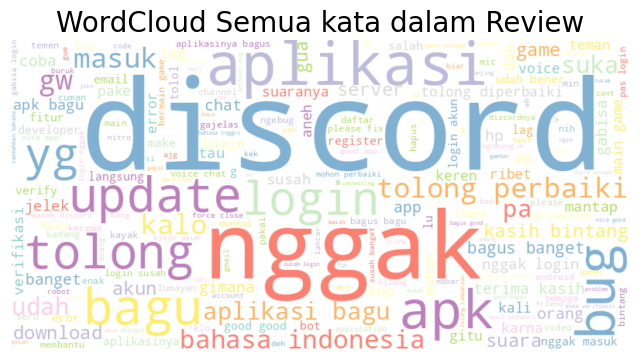

In [24]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Gabungkan semua teks
text = ' '.join([' '.join(words) for words in df_review_df['text_stopword']])

# Buat WordCloud dengan warna terang
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',  # Latar belakang putih
    colormap='Set3'            # Warna teks terang
).generate(text)

# Tampilkan
plt.figure(figsize=(8, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud Semua kata dalam Review", fontsize=20)
plt.show()


In [25]:
pd.set_option('display.max_colwidth', 300)

positif_tweets = df_review_df[df_review_df['polarity'] == 'positif'] # Megambil review dengan tweet positif
positif_tweets = positif_tweets[['text_akhir', 'polarity_score', 'polarity','text_stopword']]
positif_tweets = positif_tweets.sort_values(by='polarity_score', ascending=False)
positif_tweets = positif_tweets.reset_index(drop=True)

# Menambahkan 1 ke semua indeks DataFrame.
positif_tweets.index += 1

In [26]:
pd.set_option('display.max_colwidth', 300)
negatif_tweets = df_review_df[df_review_df['polarity'] == 'negatif'] # Megambil review dengan tweet negatif
negatif_tweets = negatif_tweets[['text_akhir', 'polarity_score', 'polarity','text_stopword']]
negatif_tweets = negatif_tweets.sort_values(by='polarity_score', ascending=True)
negatif_tweets = negatif_tweets[0:10]
negatif_tweets = negatif_tweets.reset_index(drop=True)

# Menambahkan 1 ke semua indeks DataFrame.
negatif_tweets.index += 1

In [27]:
pd.set_option('display.max_colwidth', 300)

# Ambil review netral
netral_tweets = df_review_df[df_review_df['polarity'] == 'netral']

# Pilih kolom-kolom penting aja
netral_tweets = netral_tweets[['text_akhir', 'polarity_score', 'polarity', 'text_stopword']]

# Urutkan berdasarkan skor mendekati 0 (netral), jadi dari terkecil ke terbesar pakai nilai absolut
netral_tweets = netral_tweets.reindex(netral_tweets['polarity_score'].abs().sort_values().index)

# Reset index dan mulai dari 1
netral_tweets = netral_tweets.reset_index(drop=True)
netral_tweets.index += 1

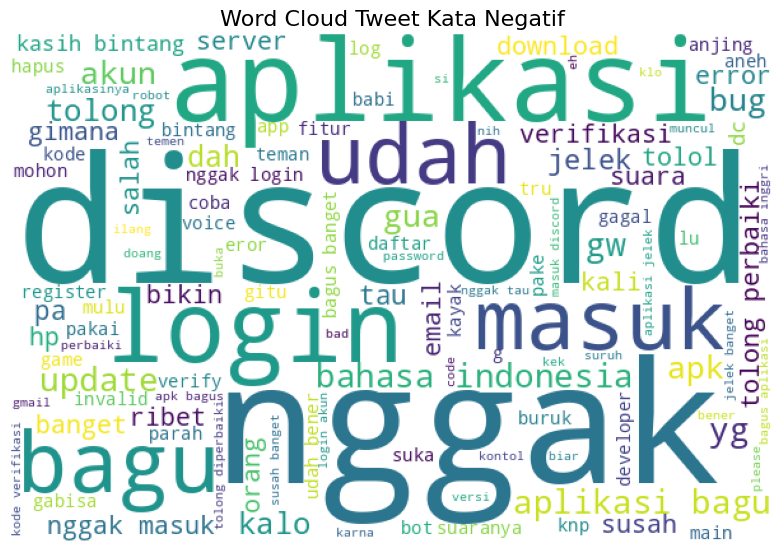

In [28]:
list_words = ''

negatif_tweets = df_review_df[df_review_df['polarity'] == 'negatif']

for tweet in negatif_tweets['text_stopword']:
    for word in tweet:
        list_words += ' ' + (word)

wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Word Cloud Tweet Kata Negatif', fontsize=16)
ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')
plt.show()


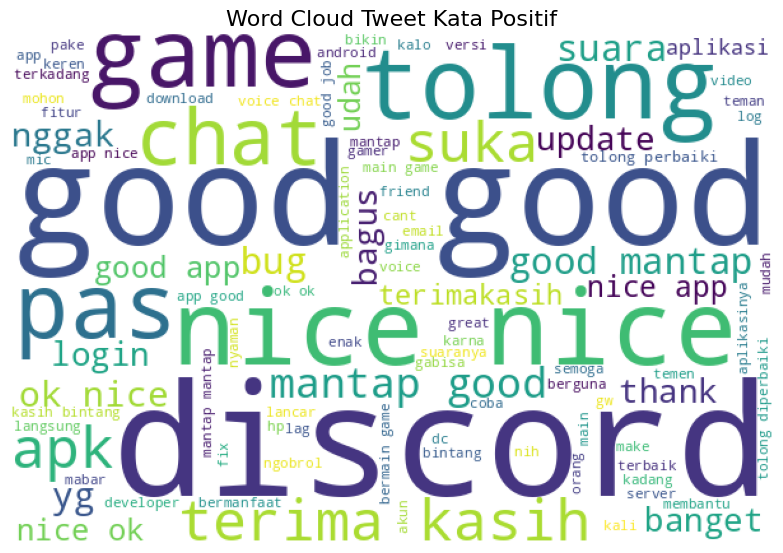

In [29]:
list_words = ''

for tweet in positif_tweets['text_stopword']:
    for word in tweet:
        list_words += ' ' + (word)

wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Word Cloud Tweet Kata Positif', fontsize=16)

ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')

plt.show()

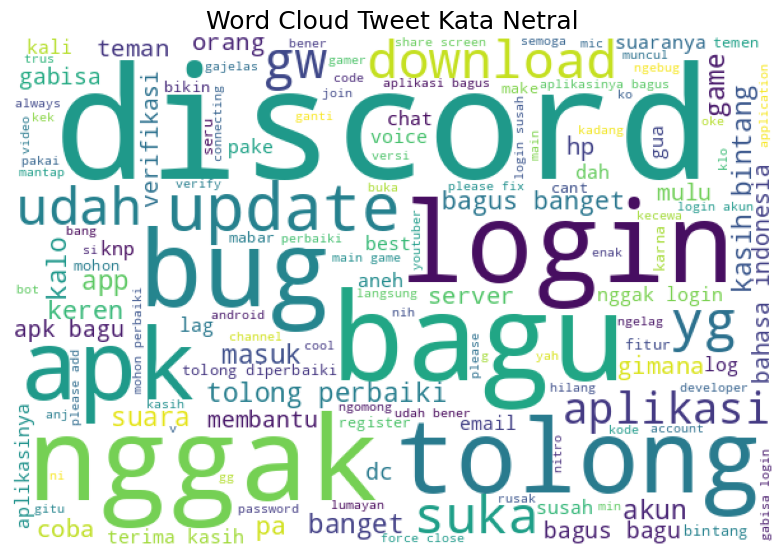

In [30]:
list_words = ''

netral_tweets = df_review_df[df_review_df['polarity'] == 'netral']

for tweet in netral_tweets['text_stopword']:
    for word in tweet:
        list_words += ' ' + (word)

wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Word Cloud Tweet Kata Netral', fontsize=18)

ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')

plt.show()

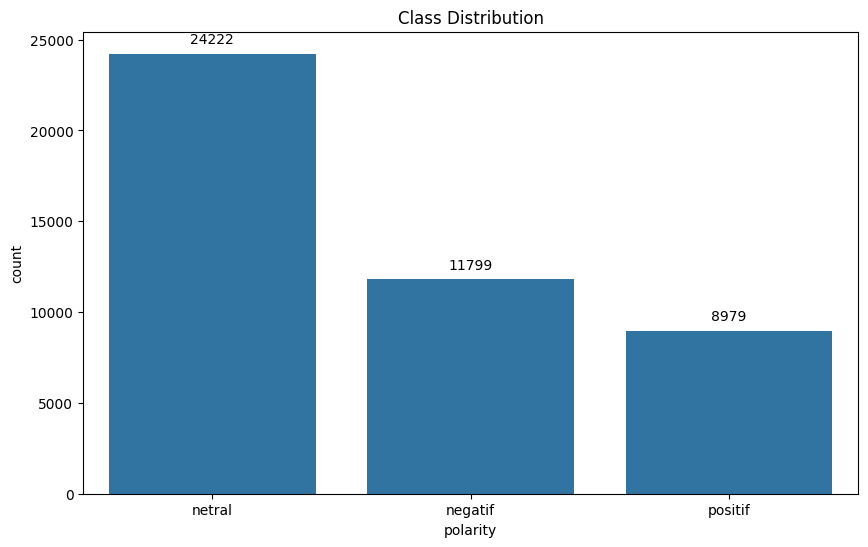

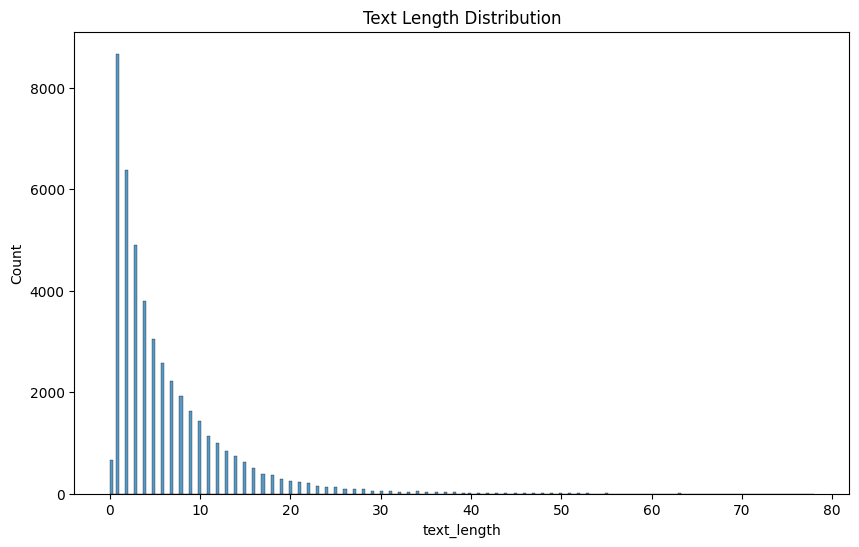

In [31]:
plt.figure(figsize=(10, 6))

# Memeriksa distribusi kelas
class_dist_plot = sns.countplot(x='polarity', data=df_review_df)
plt.title('Class Distribution')

for p in class_dist_plot.patches:
    class_dist_plot.annotate(format(p.get_height(), '.0f'),
                              (p.get_x() + p.get_width() / 2., p.get_height()),
                              ha='center', va='center',
                              xytext=(0, 10),
                              textcoords='offset points')
plt.show()

plt.figure(figsize=(10, 6))

# Visualize distribusi panjang teks
df_review_df['text_length'] = df_review_df['text_akhir'].apply(lambda x: len(x.split()))
sns.histplot(df_review_df['text_length'])
plt.title('Text Length Distribution')
plt.show()

<ipython-input-32-f99e0572c8cb>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(freqs), y=list(words), palette='mako')


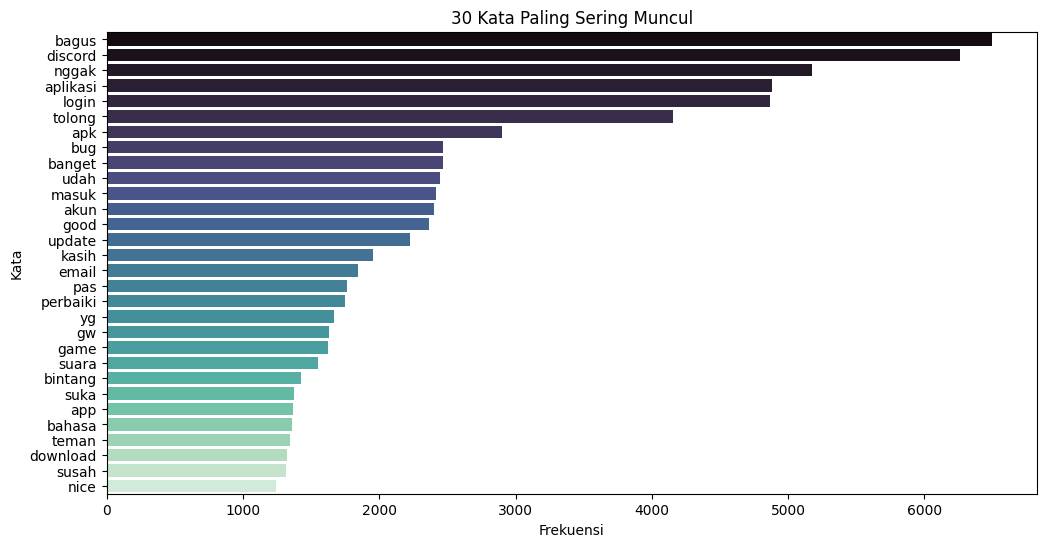

In [32]:
common_words = word_freq.most_common(30)

top_words = common_words[:30]
words, freqs = zip(*top_words)

plt.figure(figsize=(12, 6))
sns.barplot(x=list(freqs), y=list(words), palette='mako')
plt.title('30 Kata Paling Sering Muncul')
plt.xlabel('Frekuensi')
plt.ylabel('Kata')
plt.show()


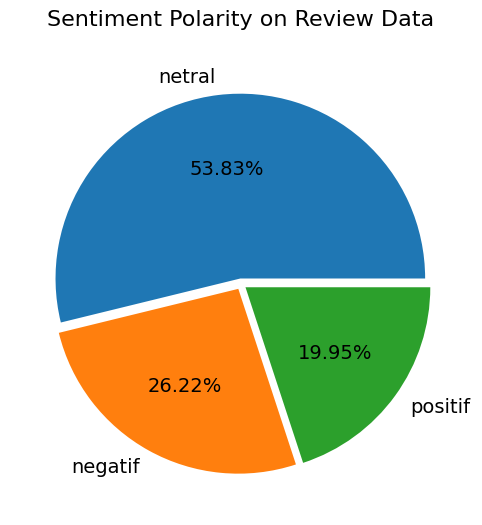

In [33]:
fig, ax = plt.subplots(figsize=(8, 6))
sizes = [count for  count in df_review_df['polarity'].value_counts()]

labels = list(df_review_df['polarity'].value_counts().index)
explode = (0.03, 0.03, 0.03)
ax.pie(x=sizes, labels=labels, autopct='%1.2f%%', explode=explode, textprops={'fontsize': 14})
ax.set_title('Sentiment Polarity on Review Data', fontsize=16, pad=20)
plt.show()

#PELATIHAN MODEL DAN FEATURE EXTRACTION

Skema 1

In [36]:
# Data Split
X = df_review_df['text_akhir']
y = df_review_df['polarity']

# Encode label
le = LabelEncoder()
y_encode = le.fit_transform(y)
y_cat = to_categorical(y_encode)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, stratify=y_cat, random_state=42)

# Tokenizer
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding
maxlen = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen, padding='post')

# Hitung class weight
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(np.argmax(y_cat, axis=1)), y=np.argmax(y_cat, axis=1))
class_weights_dict = dict(enumerate(class_weights))

print("X_train_pad shape:", X_train_pad.shape)
print("X_test_pad shape:", X_test_pad.shape)

# Model LSTM
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=maxlen))
model.add(Bidirectional(LSTM(128, return_sequences=False)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Training
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(X_train_pad, y_train, validation_split=0.2, epochs=5, batch_size=128,
                    class_weight=class_weights_dict, callbacks=[early_stop], verbose=1)

# Evaluate on Train and Test
train_loss, train_acc = model.evaluate(X_train_pad, y_train, verbose=0)
test_loss, test_acc = model.evaluate(X_test_pad, y_test, verbose=0)
print(f"LSTM - Train Accuracy: {train_acc:.4f}")
print(f"LSTM - Test Accuracy: {test_acc:.4f}")

X_train_pad shape: (36000, 100)
X_test_pad shape: (9000, 100)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 168s 730ms/step - accuracy: 0.6265 - loss: 0.7354 - val_accuracy: 0.8636 - val_loss: 0.3242
Epoch 2/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 198s 713ms/step - accuracy: 0.9152 - loss: 0.1961 - val_accuracy: 0.8957 - val_loss: 0.2668
Epoch 3/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 163s 723ms/step - accuracy: 0.9479 - loss: 0.1251 - val_accuracy: 0.9069 - val_loss: 0.2637
Epoch 4/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 160s 713ms/step - accuracy: 0.9599 - loss: 0.1001 - val_accuracy: 0.9100 - val_loss: 0.2656
Epoch 5/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 161s 716ms/step - accuracy: 0.9678 - loss: 0.0835 - val_accuracy: 0.9126 - val_loss: 0.2903
LSTM - Train Accuracy: 0.9520
LSTM - Test Accuracy: 0.9134


Skema 2

In [37]:
# Pastikan 'text_stopword' berupa string
df_review_df['text_stopword'] = df_review_df['text_stopword'].apply(
    lambda x: ' '.join(x) if isinstance(x, list) else str(x)
)

# Label mapping
label_map = {'positif': 2, 'netral': 1, 'negatif': 0}
text_data = df_review_df['text_stopword']
labels = df_review_df['polarity'].map(label_map)

# Split 80/20
X_train, X_test, y_train, y_test = train_test_split(
    text_data, labels, test_size=0.2, random_state=42
)

# TF-IDF dengan peningkatan performa
tfidf = TfidfVectorizer(
    max_features=3000,
    ngram_range=(1, 2),
    min_df=3,
    max_df=0.9,
    sublinear_tf=True
)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# SVM dengan parameter disesuaikan
model = LinearSVC(C=1.0, max_iter=1000)
model.fit(X_train_tfidf, y_train)

# Evaluasi
y_pred = model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
print("Akurasi Model SVM:", round(accuracy * 100, 2))


Akurasi Model SVM: 86.58


Skema 3

In [38]:
# Pastikan kolom teks bertipe string
X = df_review_df['text_stopword'].astype(str)
y = df_review_df['polarity']

# TF-IDF vectorization
tfidf = TfidfVectorizer(max_features=3000)
X_tfidf = tfidf.fit_transform(X)

# Label encoding
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y_encoded, test_size=0.3, stratify=y_encoded, random_state=42
)

# Train model Random Forest
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)

# Predict
y_pred = rf_model.predict(X_test)

# Evaluation
print("Akurasi:", accuracy_score(y_test, y_pred))
print("Laporan Klasifikasi:\n", classification_report(y_test, y_pred, target_names=le.classes_))


Akurasi: 0.8571111111111112
Laporan Klasifikasi:
               precision    recall  f1-score   support

     negatif       0.84      0.82      0.83      3540
      netral       0.85      0.90      0.88      7266
     positif       0.91      0.79      0.84      2694

    accuracy                           0.86     13500
   macro avg       0.87      0.84      0.85     13500
weighted avg       0.86      0.86      0.86     13500



#KESIMPULAN

Dari ketiga skema percobaan, skema 1 menhgasilkan akurasi paling baik yaitu LSTM - Train Accuracy: 0.9520
LSTM - Test Accuracy: 0.9134

In [39]:
!pip freeze > requirements.txt